# Load Existing Signals
There are cases where you have trained models and already computed the signals. In this tutorial, we will show how Privacy meter can load the existing signals to perform the attacks

In [4]:
from privacy_meter.audit_report import ROCCurveReport
from privacy_meter.constants import InferenceGame
from privacy_meter.information_source import InformationSource
from privacy_meter.audit import Audit, MetricEnum


## Loading the signals for population attacks

For the population attack, the adversary needs to compute the signals on the members, non-members and population data sampled from the same distribution. In this case, you need to provide three `npz` files with name `PopulationMetric_target_member.npz`, `PopulationMetric_target_non_member.npz` and `PopulationMetric_reference.npz`. In this example, we provide the pre-computed signals in the `existing_signals/population` folder.

In [35]:
# First, construct the dummy information source.
target_info_source = InformationSource(
    models=[],
    datasets=[]
)

reference_info_source = InformationSource(
    models=[],
    datasets=[] 
)

audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    logs_directory_names="existing_signals/population/" # Indicate the folder where the signals are saved.
)
audit_obj.prepare() #Load the signals from the disk
audit_results = audit_obj.run()[0] # Run the attack


Results are stored in: ['existing_signals/population/']


In [31]:
# Plot the results
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'

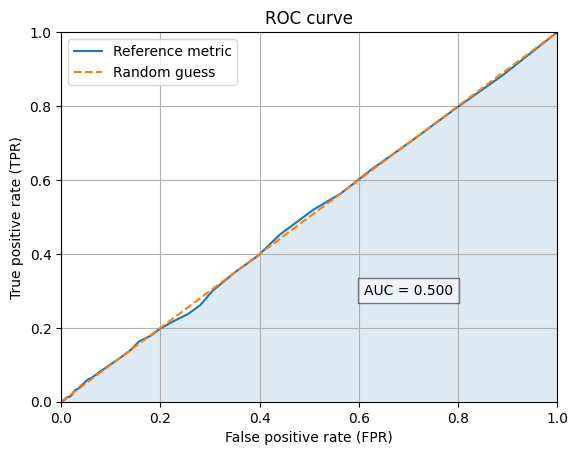

<Figure size 640x480 with 0 Axes>

In [32]:
ROCCurveReport.generate_report(
    metric_result=audit_results,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

## Loading the signals for reference attacks
For the reference attacks, the adversary needs to compute the signals for the members and non-members from the target model and compare them with the signals compute on the members and non-members from the reference models. Therefore, we need to have four signal files named as `ReferenceMetric_target_member.npz`, `ReferenceMetric_target_non_member.npz`, `ReferenceMetric_reference_member.npz` and `ReferenceMetric_reference_non_member.npz`. In this example, we provide the pre-computed signals in the `existing_signals/reference` folder.


In [33]:
# First, construct the dummy information source.
target_info_source = InformationSource(
    models=[],
    datasets=[]
)

reference_info_source = InformationSource(
    models=[],
    datasets=[] 
)

audit_obj = Audit(
    metrics=MetricEnum.REFERENCE,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    logs_directory_names="existing_signals/reference/" # Indicate the folder where the signals are saved.
)
audit_obj.prepare() #Load the signals from the disk
audit_results = audit_obj.run()[0] # Run the attack


Results are stored in: ['existing_signals/reference/']


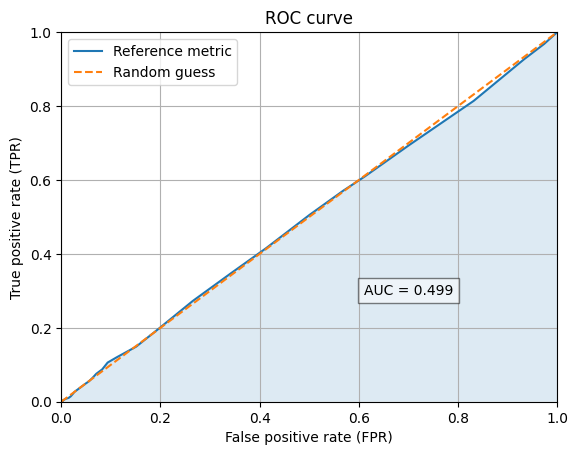

<Figure size 640x480 with 0 Axes>

In [34]:
# Plot the results
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'
ROCCurveReport.generate_report(
    metric_result=audit_results,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)